## Ranking algorithms
### Authors: Amanda Bower, Lalit Jain
In this notebook, we develop three rank aggregation algorithms for the MMLS poster competition. We will use the Borda, Bradley-Terry-Luce, and Kemeny aggregation methods. For the Kemeny aggregation, we provide brute force code, an implementation using ``lpsolve`` and an implementation using ``cvxopt/.glpk``.

For more details, see LINK TO SHARELATEX PDF.

Throughout our code, a partial ranking denotes a list of the form ``[a,b,c,...]`` which indicates that item `a` is better than item `b`, item `b` is better than item `c` etc. 

In [1]:
import random
from itertools import combinations, permutations
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# UTILITY FUNCTIONS

def build_N(rankings, n):
    '''
    Builds a nxn matrix from a set of rankings where the i-jth entry is the number of times i beats j
    rankings: a list of (partial) rankings
    n: number of items
    
    returns:
    N: nxn matrix whose (i,j)th entry is # times i beat j
    '''
    N = np.zeros((n,n))
    for r in rankings:
        for i in range(len(r)):
            for j in range(i+1, len(r)):
                N[r[i],r[j]] += 1
    return N

def kendalltau_dist(rank, partial):
    '''
    Computes the Kendall-Tau distance between a FULL ranking (rank) and a PARTIAL ranking (partial). 
    The Kendall-Tau distance in this case is the number of pairs (i,j) where rank ranks i and j in a different
    order from partial. If partial is a full ranking, this is the normal Kendall-Tau distance.
    '''
    d = 0
    rank_inv = dict(zip(rank, range(len(rank)) ))
    for i in range(len(partial)):
        for j in range(i+1, len(partial)):
            if rank_inv[partial[i]] > rank_inv[partial[j]]:
                d+=1
    return d

### Kemeny Aggregation Code
Kemeny aggregation finds a full ranking that minimizes the average distance to a set of partial rankings. In general
a difficult combinatorial optimization problem, it can be reformulated as an integer linear program in an easy way.

Our code is loosely based on the method here [http://vene.ro/blog/kemeny-young-optimal-rank-aggregation-in-python.html#note3](vene's blog).

In [2]:
def build_objective(N, extend=False):
    '''
    Returns the objective for the linear program.
    '''
    return N.ravel()

def build_constraints(n, solver='lpsolve'):
    '''
    In the lp formulation of Kemeny rank aggregation a nxn 0-1 matrix x is used to encode the permutation. 
    x satisfies: x[i,j] + x[j,i] = 1, and x[i,j]+x[j,k]+x[k,i] >= 1
    
    This method builds these constraints in the appropriate form for lpsolve and glpk.
    '''
    idx = lambda i, j: n * i + j

    #n choose 2 rows by n^2. rows are constraints and columns correspond to variables
    pairwise_constraints = np.zeros(((n * (n - 1)) / 2, n ** 2))
    for row, (i, j) in zip(pairwise_constraints, combinations(range(n), 2)):
        row[[idx(i, j), idx(j, i)]] = 1
    # and for every cycle of length 3
    triangle_constraints = np.zeros(((n * (n - 1) *(n - 2)), n ** 2))
    for row, (i, j, k) in zip(triangle_constraints, permutations(range(n), 3)):
        row[[idx(i, j), idx(j, k), idx(k, i)]] = 1

    if solver=='lpsolve':
        constraints = np.vstack([pairwise_constraints, triangle_constraints])
        constraint_rhs = np.hstack([np.ones(len(pairwise_constraints)),
                                    np.ones(len(triangle_constraints))])
        constraint_signs = np.hstack([np.zeros(len(pairwise_constraints)),
                                      np.ones(len(triangle_constraints))])   # ==
        return constraints, constraint_rhs, constraint_signs
    elif solver=='glpk':
        G = -1*triangle_constraints
        h = -1*np.ones(len(G))
        A = pairwise_constraints
        b = np.ones(len(A))
        return G,h,A,b
    else:
        raise

def kemeny_lpsolve(rankings, n):
    '''
    Kemeny rank aggregation using lpsolve55
    '''
    from lp_solve import lp_solve
    N = build_N(rankings, n)
    c = -1*build_objective(N)
    constraints, constraint_rhs, constraint_signs = build_constraints(n, 'lpsolve')
    obj, x, duals = lp_solve(c, constraints, constraint_rhs, constraint_signs.T)
                             #xint=range(1, 1 + n_candidates ** 2))
    x = np.array(x).reshape((n, n))
    aggr_rank = x.sum(axis=0)
    return obj, np.argsort(aggr_rank)[::-1], x

def kemeny_glpksolve(rankings,n):
    '''
    Kemeny rank aggregation using lpsolve55
    '''
    from cvxopt import matrix
    from cvxopt.glpk import ilp
    N = build_N(rankings, n)
    c = build_objective(N)
    G,h,A,b = build_constraints(n, 'glpk')
    status, x = ilp(c, matrix(G), matrix(h), matrix(A), matrix(b),
                    set(range(n**2)), set(range(n**2)))
    x = np.array(x).reshape((n, n))
    aggr_rank = x.sum(axis=0)
    return None, np.argsort(aggr_rank)[::-1], x

def rankaggr_brute(ranks, n):
    '''
    Kemeny rank aggregation using brute force methods. 
    DO NOT USE FOR n>9!!!
    '''
    min_dist = np.inf
    best_rank = None
    count =0
    for candidate_rank in permutations(range(n)):
        if count % 100000 == 0:
            print 'Candidate ', count
        count +=1
        dist = np.sum(kendalltau_dist(candidate_rank, rank) for rank in ranks)
        if dist < min_dist:
            min_dist = dist
            best_rank = candidate_rank
    return min_dist, best_rank



### Borda

In [3]:
def borda_reduction(rankings, n):
    '''
    Basic Borda Reduction method for computing the winner. 
    Computes the pairwise matrix N, and then normalizes the entries by the number of times i was compared to j.
    '''
    N = build_N(rankings, n)
    M = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if i!=j:
                total = N[i,j]+N[j,i]
                if total == 0:
                    M[i,j] = 0
                else:
                    M[i,j] = N[i,j]*1.0 / total
    return np.argsort(np.sum(M, axis=1))[::-1]

### Bradley-Terry-Luce

In [4]:
def btl(rankings, n):
    """
    Uses LogisticRegression to compute the btl scores based on the rankings. 
    """
    from sklearn.linear_model import LogisticRegression
    X,y = get_X_y(rankings, n)
    model = LogisticRegression(fit_intercept=False, verbose=True, C=1000000.)
    # parameter C controls regularization. High C => less regularization
    model = model.fit(X,y)
    return np.argsort(model.coef_.flatten())[::-1]

def get_X_y(rankings,n):
    '''
    Build the X and y matrices for the Logistic regression classifier.
    '''
    num_comparisons = 0
    for r in rankings:
        num_comparisons += len(r)*(len(r)-1)/2
    num_comparisons = num_comparisons
    X = np.zeros((num_comparisons,n))
    y = np.zeros((num_comparisons))
    comparison =0
    for r in rankings:
        for i in range(len(r)-1):
            for j in range(i+1, len(r)):
                lower  = min(r[i], r[j])
                higher = max(r[i], r[j])
                X[comparison, lower]=1
                X[comparison, higher]=-1
                if(lower == r[i]):
                    y[comparison] = 1
                else:
                    y[comparison] = -1
                comparison +=1

    return X, y


### Validation on non-noisy data
In this example, we demonstrate the correctness of the above data on non-noisy data. 

In [5]:
def sample(rank, k, t):
    '''
    Generates a sample of partial rankings sampled from this ranking.
    rank: full ranking to sample from
    k: items per partial ranking
    t: number of partial rankings
    
    ranks: list of output rankings, a ranking [a,b,c, ..] implies that a>b>c>...
    '''
    n = len(rank)
    ranks = []
    for i in range(t):
        ranks.append([rank[x] for x in sorted(random.sample(range(n),k))])
    return ranks
   
# generate true ranking on 50 items, 5 ranks per, 250 samples
n = 50; k = 5; num_samples = 300
tau = range(n); random.shuffle(tau)

# generate a large sample of partial rankings of size k from tau
i = 50
scores = []
while i < num_samples:
    print 'num samples:', i
    ranks = sample(tau, k, i)
    _, kemeny_aggr, x_lpsolve = kemeny_lpsolve(ranks, n)
    borda_aggr = borda_reduction(ranks, n)
    btl_aggr = btl(ranks, n)
    scores.append([kendalltau_dist(tau, kemeny_aggr), 
                   kendalltau_dist(tau, borda_aggr), 
                   kendalltau_dist(tau, btl_aggr)])
    i = min(i+50, num_samples)

num samples: 50


lp_solve.py:38: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if f == None:


m,n 118825 2500
[LibLinear]num samples: 100
m,n 118825 2500
[LibLinear]num samples: 150
m,n 118825 2500
[LibLinear]num samples: 200
m,n 118825 2500
[LibLinear]num samples: 250
m,n 118825 2500
[LibLinear]

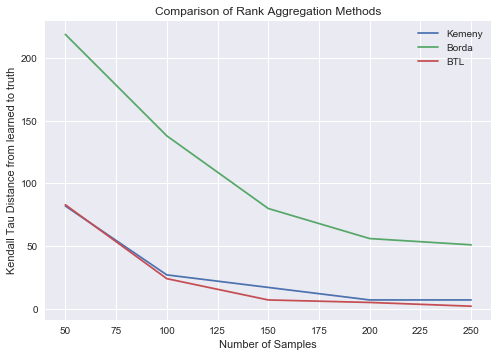

In [6]:
scores = np.array(scores)
plt.plot(np.arange(50, num_samples, 50), scores[:,0], label='Kemeny')
plt.plot(np.arange(50, num_samples, 50), scores[:,1], label='Borda')
plt.plot(np.arange(50, num_samples, 50), scores[:,2], label='BTL')
plt.xlabel('Number of Samples')
plt.ylabel('Kendall Tau Distance from learned to truth')
plt.title('Comparison of Rank Aggregation Methods')
plt.legend()
plt.show()

